# Passo 1

## Importações necessárias

In [18]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import random

## Definição de funções

### Função de leitura

In [19]:
def load_spam_collection(data_path, seed=123):
    spamfilter_df = pd.read_csv(data_path, delimiter='\t', header=None)
    spamfilter_df.columns = ['label', 'message']
    
    ''' 
        All labels were changed to the following classification: 
        spam is converted to 1 and ham to 0.
    '''
    spamfilter_df['label'] = spamfilter_df['label'].apply(
        lambda x: 1 if(x == 'spam')
        else 0
    )

    '''
    Adding an additional column that represents the number of letters 
    per message, thus creating a table that provides the sample size information.
    '''
    spamfilter_df['sample_length'] = spamfilter_df['message'].apply(lambda x: len(x))

    return spamfilter_df

### Funções de análise de dados

In [20]:
def get_num_documents(spamfilter_df):
    return spamfilter_df.count()['label']


def get_num_words_per_document(spamfilter_df):
    sample_message = spamfilter_df['message'].tolist()
    num_words = [len(s.split()) for s in sample_message]
    return np.median(num_words)


def get_num_classes(spamfilter_df):
    return spamfilter_df.nunique()['label']


def plot_sample_length_distribuition(spamfilter_df):
    sns.histplot(
        spamfilter_df['sample_length'],
        kde=True,
        bins=50,
        color='blue'
    )


def plot_class_distribuition(spamfilter_df):
    labels = spamfilter_df['label'].value_counts()
    lp = labels.plot(kind='barh', color=['#66c2a5', '#fc8d62'])
    lp.set_yticks([0, 1])
    lp.set_yticklabels(['Ham', 'Spam'])

## Aplicando a análise

In [21]:
data_path = "data/SMSSpamCollection"  # You may need to change the directory on your machine for it to work.
spam_df = load_spam_collection(data_path)

spam_df.head()

,label,message,sample_length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [22]:
num_doc = get_num_documents(spam_df)
print(f"Número total de documentos: {num_doc}")

Número total de documentos: 5572


In [23]:
num_word_per_document = get_num_words_per_document(spam_df)
print(f"Número médio de palavras por documento: {num_word_per_document}")

Número médio de palavras por documento: 12.0


In [24]:
num_classes = get_num_classes(spam_df)
print(f"Número de classes: {num_classes}")

Número de classes: 2


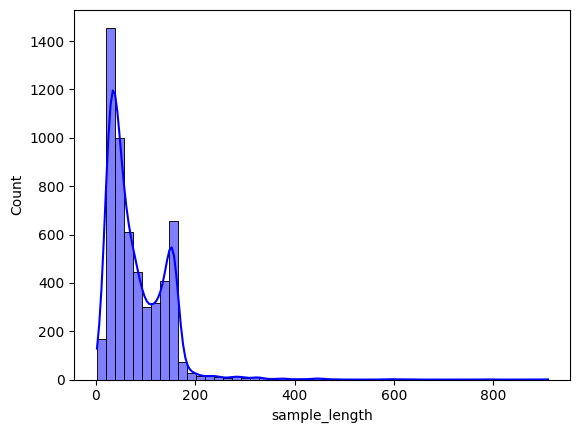

In [25]:
plot_sample_length_distribuition(spam_df)

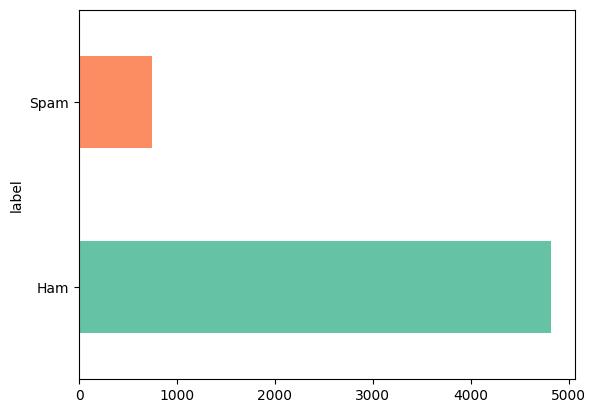

In [26]:
plot_class_distribuition(spam_df)

# Passo 2

## Importações necessárias

In [27]:
import spacy
import nltk
from nltk.stem import WordNetLemmatizer # utilizado para fazer lematização do texto
from spacy.lang.en.stop_words import STOP_WORDS
import string
import re # biblioteca para utilizar expressão regulares
from wordcloud import WordCloud # biblioteca para criar uma núvem de palavras
import contractions # usado para expandir as possíveis contrações do texto

## Preprando dados para pré-processamento

In [28]:
nlp = spacy.load("en_core_web_sm")
stop_words = STOP_WORDS
# stop_words

In [29]:
punctuation = string.punctuation
# punctuation

In [30]:
nltk.download('wordnet') # download para fazer a lematização do texto usando WordNetLematizer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Função que pré-processa os dados

In [31]:
def contraction_text(texts):
    ''' 
        This function is used to expand the possible hiring of some words in the text
    '''
    
    expanded_text = []
    for word in texts.split():
        expanded_text.append(contractions.fix(word))

    texts = ' '.join(expanded_text)
    
    return texts

In [32]:
def lemmatizer_text(texts):
    ''' 
    function responsible for lemmatizing the text
    '''
    
    lemmatizer = WordNetLemmatizer()
    
    word_token = texts.split()
    lemmas = [lemmatizer.lemmatize(word, pos='v') for word in word_token]

    texts = ' '.join(lemmas)

    return texts

In [33]:
def processing(texts):
    texts = contraction_text(texts)
    texts = lemmatizer_text(texts)
    
    result = []
    pos_tag = ['ADJ', 'NOUN', 'VERB', 'PROPN'] # vetor que permite escolher somente entre adjetivos, substantivos, verbos e pronomes
    text = re.sub(r'(https?://[^\s\n\r]+|www\.[^\s\n\r]+|[0-9@#&!?:,.\)\(;])', '', texts) # expressão regular que retira do texto todos os números, simbolos (&#;) e URL
    doc = nlp(text.lower())

    for token in doc:
        if(token.text in stop_words or token.text in punctuation or len(token.text) <= 3 or token.text == "ltgt"):
            continue
        
        if(token.pos_ in pos_tag):
            result.append(token.text)
        
        text = ' '.join(str(element) for element in result if not element.isdigit())
    
    return text

## Aplicando o pré-processamento

In [34]:
spam_df.message = spam_df.message.astype(str)
spam_df['processed_message'] = spam_df['message'].apply(processing)

spam_df.head()

,label,message,sample_length,processed_message
0,0,"Go until jurong point, crazy.. Available only ...",111,jurong point crazy available bugis great world...
1,0,Ok lar... Joking wif u oni...,29,joking
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp final tkts text receive e...
3,0,U dun say so early hor... U c already then say...,49,early
4,0,"Nah I don't think he goes to usf, he lives aro...",61,think live


## Vizualização do resultado final

In [35]:
total_message = spam_df['processed_message'].values
result_total_message = ''

for word in total_message:
    result_total_message += word + " "

# result_total_message

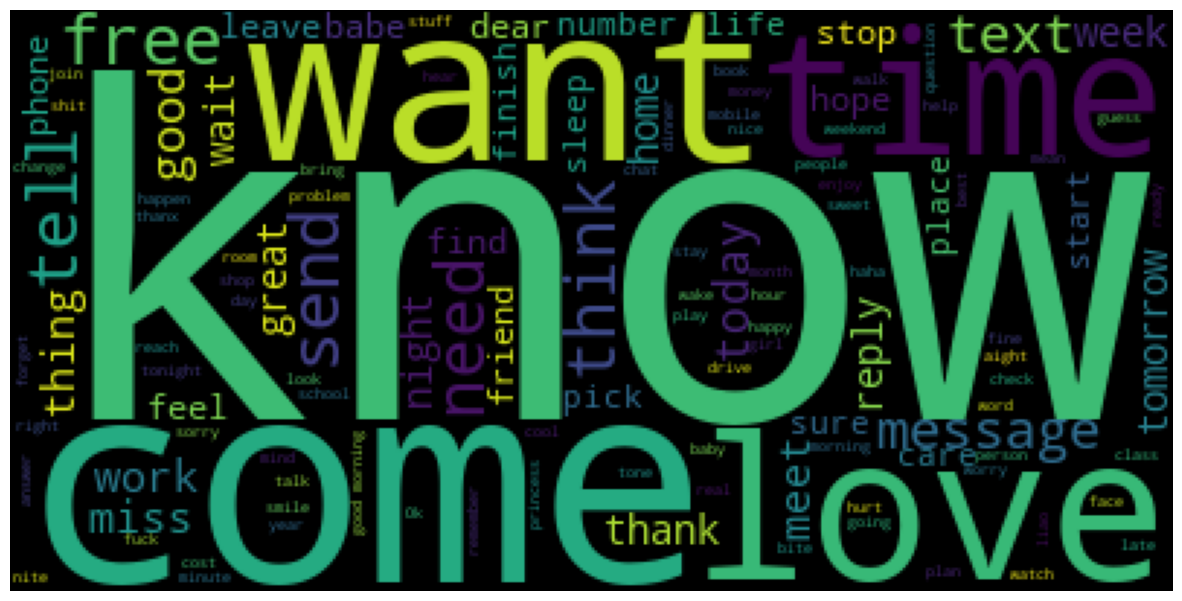

In [36]:
'''
Vizualizando o resultado final do pré-processamento
com núvem de palavras
'''
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(WordCloud().generate(result_total_message))

# Passo 3

## Importações necessárias

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

## Dados separados para treino e testes

In [42]:
'''
80% para treino e 20% para teste. Mantendo a proporção de emails spam e ham.
Utilizando para isso o parâmetro stratify.
'''

X_train, X_test, y_train, y_test = train_test_split(
    spam_df['processed_message'],
    spam_df['label'],
    test_size=0.2,
    stratify=spam_df['label'],
    random_state=42
)

## Função de vetorização que utiliza TF-IDF

In [43]:
def tfid_vectorize(X_train, X_test):
    vectorizer = TfidfVectorizer()

    x_train = vectorizer.fit_transform(X_train)
    x_test = vectorizer.transform(X_test)

    return x_train, x_test

In [44]:
vecX_train, vecX_test = tfid_vectorize(X_train, X_test)

# Passo 4

## Importações necessárias

In [45]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn import svm
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

## Modelo SVM

### Vizualização dos dados de treinamento

In [46]:
'''
Como o  TF-IDF gera uma representação de alta dimensão, 
foi utilizado a técnica PCA (Principal Component Analysis): 
Reduz as dimensões mantendo a maior variância dos dados e ajuda
a visualizar a distribuição. Para, portanto, determinar 
se os dados têm uma relação linear ou polinomial
'''
pca = PCA(n_components=2)
vecX_pca = pca.fit_transform(vecX_train.toarray())

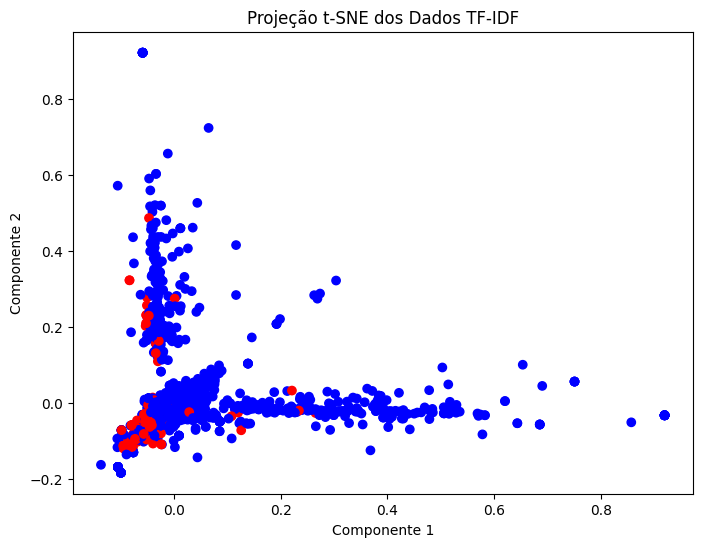

In [47]:
colors = ['blue' if label == 0 else 'red' for label in y_train]

plt.figure(figsize=(8, 6))
plt.scatter(vecX_pca[:, 0], vecX_pca[:, 1], c=colors, alpha=1)
plt.title('Projeção t-SNE dos Dados TF-IDF')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

### Treinamento do modelo

In [48]:
model_spam_filtter = svm.SVC(kernel='linear', C=1.0)
model_spam_filtter.fit(vecX_train, y_train)

y_pred = model_spam_filtter.predict(vecX_test)

### Métricas do modelo

In [86]:
print("Matriz de confusão")
print(confusion_matrix(y_test, y_pred))
print()

print(f"F1: {f1_score(y_test, y_pred)*100:,.2f}")
print(f"Acurácia: {model_spam_filtter.score(vecX_test, y_test)*100:,.2f}")

Matriz de confusão
[[946  20]
 [ 26 123]]

F1: 84.25
Acurácia: 97.13


## Modelo K-NN

### Treinamento do modelo

In [51]:
model_knn_spam = KNeighborsClassifier(n_neighbors=3)
model_knn_spam.fit(vecX_train, y_train)

y_pred = model_knn_spam.predict(vecX_test)

### Métricas do modelo

In [88]:
print("Matriz de confusão: ")
print(confusion_matrix(y_test, y_pred))
print()
print(f"F1: {f1_score(y_test, y_pred)*100:,.2f}")
print(f"Acurácia: {model_knn_spam.score(vecX_test, y_test)*100:,.2f}")

Matriz de confusão: 
[[946  20]
 [ 26 123]]

F1: 84.25
Acurácia: 92.83


## Modelo Decision Trees

### Treinamento do modelo

In [54]:
model_tree_spam = DecisionTreeClassifier()
model_tree_spam.fit(vecX_train, y_train)

y_pred = model_tree_spam.predict(vecX_test)

### Métricas do modelo

In [89]:
print("Matiz de confusão:")
print(confusion_matrix(y_test, y_pred))
print()
print(f"F1: {f1_score(y_test, y_pred)*100:,.2f}")
print(f"Acurácia: {model_spam_filtter.score(vecX_test, y_test)*100:,.2f}")

Matiz de confusão:
[[946  20]
 [ 26 123]]

F1: 84.25
Acurácia: 97.13


# Passo 5

## Importações necessárias

In [57]:
from sklearn.model_selection import GridSearchCV

## Definições de Hiperparâmetros

In [66]:
svm_params = {'C': [0.1, 1, 10], 
              'kernel': ['linear', 'rbf', 'poly'], 
              'gamma': [0.001, 0.1, 1]}

knn_params = {'n_neighbors': [3, 5, 7, 9],
              'metric': ['euclidian', 'manhattan'],
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

decision_tree_params = {'criterion': ['gini', 'entropy'],
                 'splitter':['best', 'random'],
                 'min_samples_leaf':[2, 5, 10],
                 'max_depth':[3, 5, 10], 
                 'min_samples_split':[2, 5, 10]}

## Inicialização de modelos

In [59]:
svm = svm.SVC()
knn = KNeighborsClassifier()
decision_tree = DecisionTreeClassifier()

## Método GridSearchCV

In [73]:
grid_svm = GridSearchCV(svm, param_grid=svm_params, scoring='f1_macro')
grid_knn = GridSearchCV(knn, param_grid=knn_params, scoring='f1_macro')
grid_dt = GridSearchCV(decision_tree, param_grid=decision_tree_params, scoring='f1_macro')

In [ ]:
grid_svm.fit(vecX_train, y_train)
grid_knn.fit(vecX_train, y_train)
grid_dt.fit(vecX_train, y_train)

## Vizualização de resultado

In [91]:
print("SVM: ", grid_svm.best_params_)
print(f"F1_score: {grid_svm.best_score_*100:,.2f}", )
print()
print("KNN: ", grid_knn.best_params_)
print(f"F1_score: {grid_knn.best_score_*100:,.2f}")
print()
print("Decision Tree", grid_dt.best_params_)
print(f"F1_score: {grid_dt.best_score_*100:,.2f}")

SVM:  {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
F1_score: 93.46

KNN:  {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
F1_score: 82.77

Decision Tree {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'}
F1_score: 84.50
